In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math as m
from sklearn import ensemble, tree, linear_model
import missingno as msno
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

D:\Programming\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
len(train.columns),len(test.columns)

(81, 80)

In [4]:
train.shape , test.shape

((1460, 81), (1459, 80))

In [5]:
train.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature  \
1455         Lvl    AllPub    ...            0    NaN    NaN         NaN   
1456         Lvl    AllPub    ...            0    NaN  MnPrv         NaN   
1457         Lvl    AllPub    ...            0    NaN  GdPrv        Shed   
1458         Lvl    AllPub    ...            0    NaN    NaN         NaN   
1459         Lvl    AllPub    ...            0    NaN    NaN         NaN   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455       0      8   2007        WD         Normal     175000  
1456       0      2   2010        WD         Normal     210000  
1457    2500      5   2010        WD         Normal     266500  
1458       0      4   2010        WD         Normal     142125  
1459       0      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

In [6]:
train_ID = train['Id']
test_ID = test['Id']

In [7]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

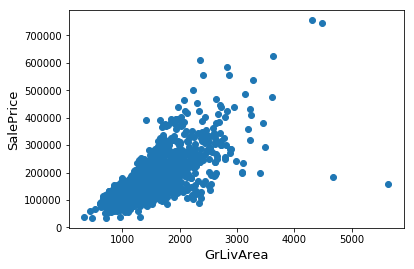

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [9]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

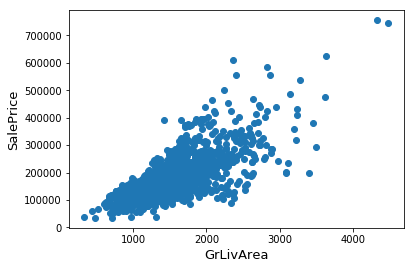

In [10]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

D:\Programming\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Programming\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 180932.92 and sigma = 79467.79



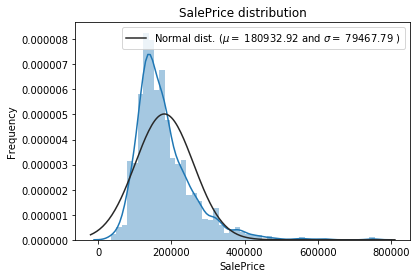

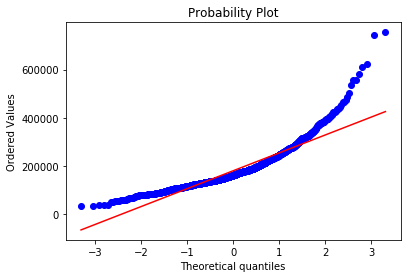

In [11]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

D:\Programming\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 12.02 and sigma = 0.40



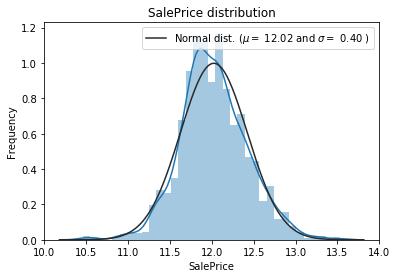

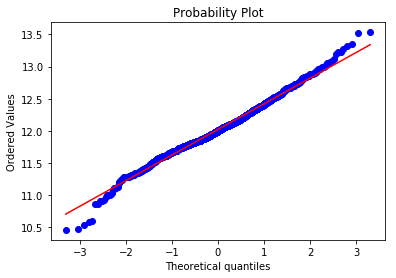

In [12]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test),sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [14]:
print ntrain,ntest

1458 1459


In [15]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

Missing Ratio
PoolQC            99.691464
MiscFeature       96.400411
Alley             93.212204
Fence             80.425094
FireplaceQu       48.680151
LotFrontage       16.660953
GarageFinish       5.450806
GarageYrBlt        5.450806
GarageQual         5.450806
GarageCond         5.450806
GarageType         5.382242
BsmtExposure       2.811107
BsmtCond           2.811107
BsmtQual           2.776826
BsmtFinType2       2.742544
BsmtFinType1       2.708262
MasVnrType         0.822763
MasVnrArea         0.788481
MSZoning           0.137127
BsmtFullBath       0.068564

Text(0.5,1,'Percent missing data by feature')

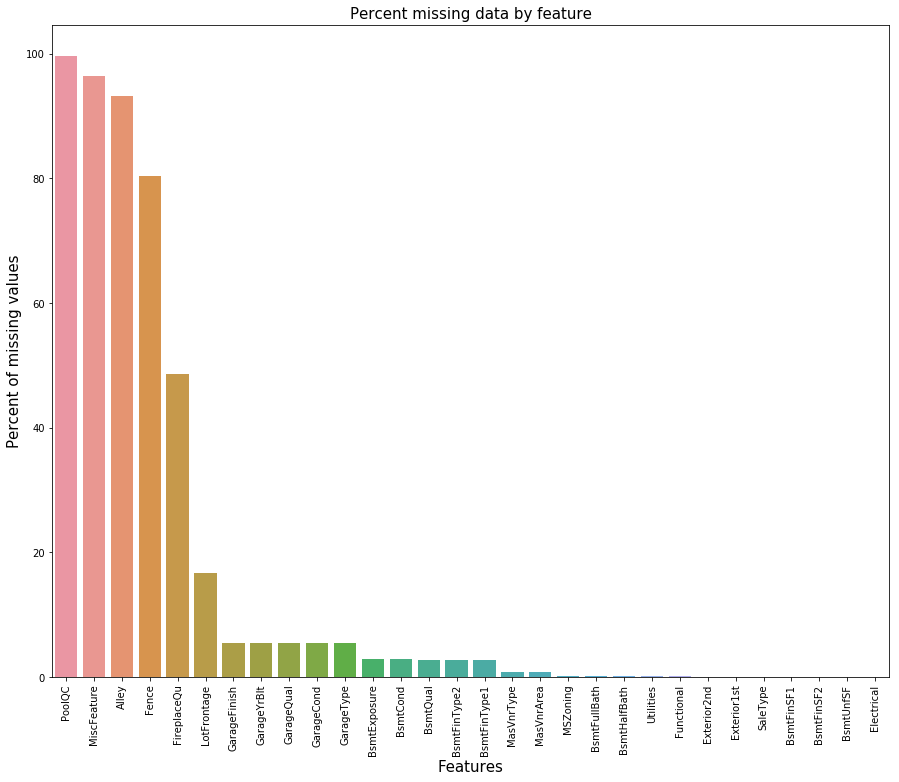

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

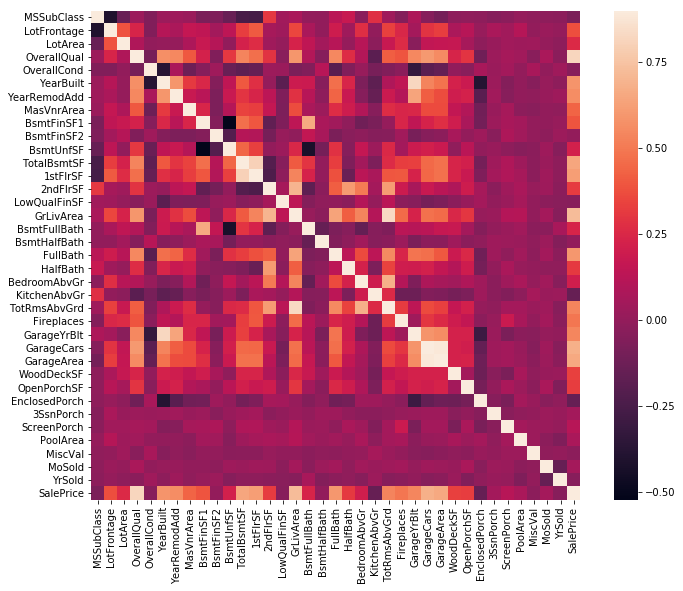

In [17]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [18]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [19]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


In [20]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [21]:
all_data.drop(['LotFrontage','GarageYrBlt','MasVnrArea'],axis=1)

MSSubClass MSZoning  LotArea Street Alley LotShape LandContour  \
0             60       RL     8450   Pave  None      Reg         Lvl   
1             20       RL     9600   Pave  None      Reg         Lvl   
2             60       RL    11250   Pave  None      IR1         Lvl   
3             70       RL     9550   Pave  None      IR1         Lvl   
4             60       RL    14260   Pave  None      IR1         Lvl   
5             50       RL    14115   Pave  None      IR1         Lvl   
6             20       RL    10084   Pave  None      Reg         Lvl   
7             60       RL    10382   Pave  None      IR1         Lvl   
8             50       RM     6120   Pave  None      Reg         Lvl   
9            190       RL     7420   Pave  None      Reg         Lvl   
10            20       RL    11200   Pave  None      Reg         Lvl   
11            60       RL    11924   Pave  None      IR1         Lvl   
12            20       RL    12968   Pave  None      IR2         Lvl   
13            20       RL    10652   Pave  None      IR1         Lvl   
14            20       RL    10920   Pave  None      IR1         Lvl   
15            45       RM     6120   Pave  None      Reg         Lvl   
16            20       RL    11241   Pave  None      IR1         Lvl   
17            90       RL    10791   Pave  None      Reg         Lvl   
18            20       RL    13695   Pave  None      Reg         Lvl   
19            20       RL     7560   Pave  None      Reg         Lvl   
20            60       RL    14215   Pave  None      IR1         Lvl   
21            45       RM     7449   Pave  Grvl      Reg         Bnk   
22            20       RL     9742   Pave  None      Reg         Lvl   
23           120       RM     4224   Pave  None      Reg         Lvl   
24            20       RL     8246   Pave  None      IR1         Lvl   
25            20       RL    14230   Pave  None      Reg         Lvl   
26            20       RL     7200   Pave  None      Reg         Lvl   
27            20       RL    11478   Pave  None      Reg         Lvl   
28            20       RL    16321   Pave  None      IR1         Lvl   
29            30       RM     6324   Pave  None      IR1         Lvl   
...          ...      ...      ...    ...   ...      ...         ...   
2887          30       RM     7030   Pave  None      Reg         Lvl   
2888          50       RM     9060   Pave  None      Reg         Lvl   
2889          30  C (all)    12366   Pave  None      Reg         Lvl   
2890         190  C (all)     9000   Pave  None      Reg         Lvl   
2891          50  C (all)     8520   Grvl  None      Reg         Bnk   
2892         120       RM     5748   Pave  None      IR1         HLS   
2893         120       RM     3842   Pave  None      IR1         HLS   
2894          20       RL    23580   Pave  None      IR1         Lvl   
2895          90       RL     8385   Pave  None      Reg         Lvl   
2896          20       RL     9116   Pave  None      Reg         Lvl   
2897          80       RL    11080   Pave  None      Reg         Lvl   
2898          20       RL    50102   Pave  None      IR1         Low   
2899          20       RL     8098   Pave  None      IR1         Lvl   
2900          20       RL    13618   Pave  None      Reg         Lvl   
2901          20       RL    11577   Pave  None      Reg         Lvl   
2902          20       RL    31250   Pave  None      Reg         Lvl   
2903          90       RM     7020   Pave  None      Reg         Lvl   
2904         160       RM     2665   Pave  None      Reg         Lvl   
2905          20       RL    10172   Pave  None      IR1         Lvl   
2906          90       RL    11836   Pave  None      IR1         Lvl   
2907         180       RM     1470   Pave  None      Reg         Lvl   
2908         160       RM     1484   Pave  None      Reg         Lvl   
2909          20       RL    13384   Pave  None      Reg         Lvl   
2910         160       RM     1533   Pave  Non

In [22]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [23]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [24]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [25]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [26]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
LandSlope       4.973254
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101

In [27]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [28]:
#all_data.drop(['PoolQC','LotFrontage','MiscFeature','Alley','Fence','FireplaceQu'],axis=1)

In [29]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [30]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [31]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [32]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)                              

In [34]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [35]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [36]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1157 (0.0064)



In [37]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [38]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0084)



In [39]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [40]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



In [41]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [42]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


In [43]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [44]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07847575710712439


In [45]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08180863543585307


In [46]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07225550554834881


In [49]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
score = rmsle(y_train,stacked_train_pred*0.08 + xgb_train_pred*0.02 + lgb_train_pred*0.90 )
print score
with open('score.txt', 'w') as file:
    file.write(str(score))

RMSLE score on train data:
0.07220793726895956


In [411]:
#ensemble = stacked_pred*0.08 + xgb_pred*0.02 + lgb_pred*0.90

In [412]:
#sub = pd.DataFrame()
#sub['Id'] = test_ID
#sub['SalePrice'] = ensemble
#sub.to_csv('submission.csv',index=False)